In [1]:
print("Hello world")

Hello world


In [2]:
# Let's say all your lyrics are stored in one big string called `all_lyrics`
with open("taylor_swift.txt", "r") as f:
    all_lyrics = f.read()

# Split into words
words = all_lyrics.split()

# Total number of words (tokens)
total_words = len(words)

# Unique words (vocabulary size)
unique_words = len(set(words))

print(f"Total words (tokens): {total_words}")
print(f"Unique words (vocab size): {unique_words}")


Total words (tokens): 21454
Unique words (vocab size): 3501


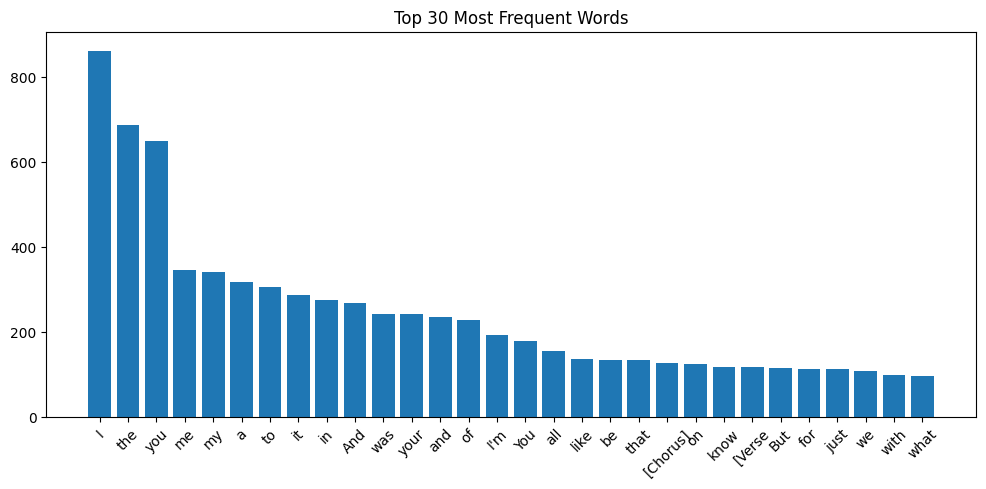

In [3]:
from collections import Counter
import matplotlib.pyplot as plt

counter = Counter(words)
common = counter.most_common(30)
labels, freqs = zip(*common)

plt.figure(figsize=(12, 5))
plt.bar(labels, freqs)
plt.xticks(rotation=45)
plt.title("Top 30 Most Frequent Words")
plt.show()


In [4]:
import torch 
from torch import nn 
from torch.nn import functional as F 
from data import TaylorSwiftDataLoader 


class Config:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    n_emb = 32
    n_head = 8
    head_size = n_emb // n_head
    block_size = 8
    dropout = 0.2

config = Config()
class Head(nn.Module):
    def __init__(self):
        super().__init__()
        self.Q = nn.Linear(config.n_emb,config.head_size,bias=False,device=config.device) # 32 ,4 
        self.K = nn.Linear(config.n_emb,config.head_size,bias=False,device=config.device)
        self.V = nn.Linear(config.n_emb,config.head_size,bias=False,device=config.device)
        self.register_buffer('tril',torch.tril(torch.ones(config.block_size,config.block_size))) 
        self.dropout = nn.Dropout(config.dropout)
    
    def forward(self,X):
        B, T, C = X.shape
    #   4, 8 , 32
        Q = self.Q(X) 
        K = self.K(X)
        # compute attention scores 
        wei = Q @ K.transpose(-2,-1) * C ** -0.5
        wei = wei.masked_fill(self.tril[:T,:T] == 0, float('-inf'))
        wei = torch.softmax(wei,dim=-1) 
        V = self.V(X)
        out = wei @ V
        print(f"Q shape: {Q.shape}, K shape: {K.shape}, V shape: {V.shape}, wei shape: {wei.shape}")
        return out 

In [7]:
dataset = TaylorSwiftDataLoader("taylor_swift.txt", block_size=8)
print("Vocab size:", dataset.get_vocab_size())

# Optional: Use DataLoader
from torch.utils.data import DataLoader

loader = DataLoader(dataset, batch_size=4, shuffle=True)
for xb, yb in loader:
    print("Input:", xb)
    print("Target:", yb)
    break

Data has 21366 words, 2427 unique.
Vocab size: 2427
Input: tensor([[1743, 2416, 1416,  992, 2086, 1038, 1746, 2091],
        [1362, 1723,  471, 1464, 1961,  992,  299, 1233],
        [2085, 1031, 1369, 1151, 2067, 1413, 1151,   10],
        [ 533,  904, 1035, 1006, 1333, 2125,  823, 2366]])
Target: tensor([[2416, 1416,  992, 2086, 1038, 1746, 2091,  706],
        [1723,  471, 1464, 1961,  992,  299, 1233,   50],
        [1031, 1369, 1151, 2067, 1413, 1151,   10, 1578],
        [ 904, 1035, 1006, 1333, 2125,  823, 2366,  845]])


In [3]:
dataset.__getitem__(1)[0]

tensor([2133, 2308,    1, 1288, 2241, 2040, 2241,  767])

In [4]:
embedding = nn.Embedding(dataset.vocab_size,config.n_emb)
head = Head()

In [5]:
xb = embedding(xb)

In [6]:
xb.shape

torch.Size([4, 8, 32])

In [7]:
output = head(xb)

Q shape: torch.Size([4, 8, 4]), K shape: torch.Size([4, 8, 4]), V shape: torch.Size([4, 8, 4]), wei shape: torch.Size([4, 8, 8])


In [8]:
output.shape

torch.Size([4, 8, 4])

In [9]:
X = []
Y = []

for i in range(len(dataset)):
    x, y = dataset[i]
    X.append(x)
    Y.append(y)

X = torch.stack(X)  # Shape: (N, block_size)
Y = torch.stack(Y)  # Shape: (N, block_size)

X = X.to(config.device)
Y = Y.to(config.device)

In [10]:
X[0]

tensor([  50, 2133, 2308,    1, 1288, 2241, 2040, 2241])

In [11]:
y[0]

tensor(10)

In [12]:
encode = lambda s: [dataset.stoi[c] for c in s]              # encoder: take a string, output a list of integers
decode = lambda l: ' '.join([dataset.itos[i] for i in l])     

In [13]:
decode([  50, 2133, 2308,    1, 1288, 2241, 2040, 2241])

'all too well 10 minute version taylors version'

In [14]:
x = dataset.get_batch('train')[0]
y = dataset.get_batch('train')[1]

In [15]:
dataset.get_batch('train')[0][1]

tensor([2311, 1767,  199,   68,  909,  982, 2067,  933])

In [16]:
dataset.get_batch('train')[1][0]

tensor([2422, 1059,   10,  869, 1006,  734, 1870, 2416])

In [18]:
def decode(ids):
    return [dataset.itos[i] for i in ids]

print(decode(x[0].tolist()))
print(decode(y[0].tolist()))

['that', 'ill', 'sue', 'you', 'if', 'you', 'step', 'on']
['im', 'begging', 'for', 'you', 'to', 'take', 'my', 'hand']


In [19]:
" ".join(dataset.data[100:120])

'more and i might be okay but im not fine at all oh oh oh chorus causе there we arе'

In [2]:
with open("taylor_swift.txt", "r", encoding="utf-8") as f:
    data = f.read().lower()


In [20]:
import re
data = re.sub(r'[^\w\s]', '', data)
words = data.split() 
vocab = sorted(list(set(words)))
vocab_size = len(vocab)
word_to_idx = {ch: i for i, ch in enumerate(vocab)}
idx_to_word = {i: ch for i, ch in enumerate(vocab)}

encode = lambda s: [word_to_idx[c] for c in s]              # encoder: take a string, output a list of integers
decode = lambda l: ''.join([idx_to_word[i] for i in l])

In [24]:
data = torch.tensor([word_to_idx[c] for c in words], dtype=torch.long) 


In [27]:
device = 'cuda' if torch.cuda.is_available() else False

In [39]:
# 1. Split data
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

# 2. Manual batch generator
def get_batch(split,batch_size=32, block_size=32):
    data_src = train_data if split == 'train' else val_data
    ix = torch.randint(len(data_src) - block_size, (batch_size,))

    x = torch.stack([data_src[i:i+block_size] for i in ix])
    y = torch.stack([data_src[i+1:i+1+block_size] for i in ix])
    print(x)
    return x,y

In [40]:
x,y = get_batch('train')

tensor([[2169, 2000, 1718,  ..., 2067, 1279, 1387],
        [1177, 1176, 1176,  ...,  296,   68,  309],
        [ 106, 2067, 1693,  ..., 2074,  264, 1440],
        ...,
        [1059, 1332,  365,  ..., 2287,  297,  124],
        [  68, 2072, 2276,  ..., 2017, 1332,  886],
        [2067, 1505,   68,  ...,  840,   10, 1177]])


In [42]:
x[0]

tensor([2169, 2000, 1718,  972, 2416, 1090, 2317, 2416, 2270,   68,  236, 2416,
         840,  936,  243, 1354,  775, 2105, 2416,   56, 1093,  121, 2240,    2,
         992,  687, 1151, 1116, 1006, 2067, 1279, 1387])

In [43]:
y[0]

tensor([2000, 1718,  972, 2416, 1090, 2317, 2416, 2270,   68,  236, 2416,  840,
         936,  243, 1354,  775, 2105, 2416,   56, 1093,  121, 2240,    2,  992,
         687, 1151, 1116, 1006, 2067, 1279, 1387, 1524])

In [ ]:
import torch 
from torch import nn 
from torch.nn import functional as F 


#------------------ Data loading --------------------------------- 

with open("taylor_swift.txt", "r", encoding="utf-8") as f:
        data = f.read().lower()

words = data.split() 
vocab = sorted(list(set(data)))
vocab_size = len(vocab)
word_to_idx = {ch: i for i, ch in enumerate(vocab)}
idx_to_word = {i: ch for i, ch in enumerate(vocab)}

encode = lambda s: [word_to_idx[c] for c in s]              # encoder: take a string, output a list of integers
decode = lambda l: ''.join([idx_to_word[i] for i in l])     # decoder: take a list of integers, output a string

# Convert the entire text into a list of indices
data = torch.tensor([word_to_idx[c] for c in data], dtype=torch.long) 


# 1. Split data
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

# 2. Manual batch generator
def get_batch(split,batch_size=32, block_size=32):
    data_src = train_data if split == 'train' else val_data
    ix = torch.randint(len(data_src) - block_size, (batch_size,))

    X = torch.stack([data_src[i:i+block_size] for i in ix])
    y = torch.stack([data_src[i+1:i+1+block_size] for i in ix])

    return X,y

# -------------------------------------------------------------------

class Config:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    n_emb = 32
    n_heads = 8
    head_size = n_emb // n_heads
    block_size = 256
    dropout = 0.2
    batch_size = 32
    lr = 1e-3

config = Config()

class Head(nn.Module):
    def __init__(self,head_size):
        super().__init__()
        self.Q = nn.Linear(config.n_emb,head_size,bias=False,device=config.device) # (B,T,head_size)
        self.K = nn.Linear(config.n_emb,head_size,bias=False,device=config.device) # (B,T,head_size)
        self.V = nn.Linear(config.n_emb,head_size,bias=False,device=config.device) # (B,T,head_size)
        self.register_buffer('tril',torch.tril(torch.ones(config.block_size,config.block_size))) # (B,T,T)
        self.dropout = nn.Dropout(config.dropout)
    
    def forward(self,X):
        B, T, C = X.shape
        Q = self.Q(X)
        K = self.K(X)
        # compute attention scores 
        wei = Q @ K.transpose(-2,-1) * C ** -0.5 # (B,T,T) 
        wei = wei.masked_fill(self.tril[:T,:T] == 0, float('-inf')) # (B,T,T)
        wei = torch.softmax(wei,dim=-1)  # (B,T,T)

        V = self.V(X) # (B,T,C)
        out = wei @ V # (B,T,T) @ (B,T,C) = (B,T,C)
        return out 


class MinGPT(nn.Module):
    def __init__(self):
        super().__init__()

        self.token_embedding_table = nn.Embedding(vocab_size,config.n_emb)
        self.head = Head(config.n_emb)
        self.lm_head = nn.Linear(config.n_emb,vocab_size) 

    def forward(self,X,targets=None):
        token_emb = self.token_embedding_table(X)
        print("Token embedding shape", token_emb.shape)
        print(X.shape)
        X = self.head(token_emb) #  (B,T,C)
        logits = self.lm_head(X)

        if targets is None:
            loss = None 
        
        else: 
            B, T, C = logits.shape
            print(logits.shape)
            logits = logits.view(B*T,C)
            targets = targets.view(B*T)
            print(logits.shape)
            print(targets.shape)
            loss = F.cross_entropy(logits,targets)

        return logits , loss
    
    def generate(self, idx, max_new_tokens):
        
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -config.block_size:]

            logits, loss = self(idx_cond)
            logits = logits[:, -1, :]  # [B, C]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs,num_samples=1) # [B, 1]
            idx = torch.cat((idx,idx_next),dim=1)
        
        return idx

model = MinGPT()
 
optimizer = torch.optim.Adam(model.parameters(),lr=config.lr)

FileNotFoundError: [Errno 2] No such file or directory: 'taylor_swift.txt'

In [24]:
Xb , yb = get_batch('train')

In [25]:
MinGPT().forward(Xb,yb)

Token embedding shape torch.Size([32, 32, 32])
torch.Size([32, 32])
torch.Size([32, 32, 63])
torch.Size([1024, 63])
torch.Size([1024])


(tensor([[ 2.3538e-01,  1.6549e-01,  1.7738e-01,  ..., -3.5974e-01,
          -4.7773e-05,  1.7951e-01],
         [ 1.6780e-01,  1.5652e-01,  1.5632e-01,  ..., -2.4889e-01,
           2.6462e-02,  2.1910e-01],
         [ 6.3478e-02,  9.3530e-02,  9.2952e-02,  ..., -2.7172e-01,
           8.4758e-02,  3.6139e-01],
         ...,
         [ 2.8028e-01,  1.6166e-01,  3.4716e-03,  ..., -2.6514e-01,
          -2.0619e-02,  1.3139e-01],
         [ 3.0659e-01,  1.5096e-01, -8.3329e-02,  ..., -2.1634e-01,
           6.9096e-03,  1.1024e-01],
         [ 2.5490e-01,  1.4774e-01, -2.2158e-02,  ..., -2.4918e-01,
           2.9944e-03,  1.8019e-01]], grad_fn=<ViewBackward0>),
 tensor(4.1158, grad_fn=<NllLossBackward0>))

In [22]:
Xb.shape

torch.Size([32, 32])

In [26]:
test_embedder = nn.Embedding(5, 3)

In [29]:
X = torch.tensor([[1, 2], [2, 4]])  # shape [2, 2]
test_embedder(X)


tensor([[[-0.4077, -0.3327, -1.1974],
         [ 0.8395, -0.6468,  0.2121]],

        [[ 0.8395, -0.6468,  0.2121],
         [-0.3389, -0.0081, -0.0601]]], grad_fn=<EmbeddingBackward0>)

In [30]:
yb.shape

torch.Size([32, 32])

In [7]:
class Config:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    n_emb = 32
    n_heads = 8
    head_size = n_emb // n_heads
    block_size = 256
    dropout = 0.2
    batch_size = 32
    lr = 1e-3

config = Config()

class Head(nn.Module):
    def __init__(self,head_size):
        super().__init__()
        self.Q = nn.Linear(config.n_emb,head_size,bias=False,device=config.device) # (B,T,head_size)
        self.K = nn.Linear(config.n_emb,head_size,bias=False,device=config.device) # (B,T,head_size)
        self.V = nn.Linear(config.n_emb,head_size,bias=False,device=config.device) # (B,T,head_size)
        self.register_buffer('tril',torch.tril(torch.ones(config.block_size,config.block_size))) # (B,T,T)
        self.dropout = nn.Dropout(config.dropout)
    
    def forward(self,X):
        B, T, C = X.shape
        Q = self.Q(X)
        K = self.K(X)
        # compute attention scores 
        wei = Q @ K.transpose(-2,-1) * C ** -0.5 # (B,T,T) 
        wei = wei.masked_fill(self.tril[:T,:T] == 0, float('-inf')) # (B,T,T)
        wei = torch.softmax(wei,dim=-1)  # (B,T,T)

        V = self.V(X) # (B,T,C)
        out = wei @ V # (B,T,T) @ (B,T,C) = (B,T,C)
        return out 

vocab_size = 3500  # Example vocab size, adjust as needed

class MinGPT(nn.Module):
    def __init__(self):
        super().__init__()

        self.token_embedding_table = nn.Embedding(vocab_size,config.n_emb)
        self.head = Head(config.n_emb)
        self.lm_head = nn.Linear(config.n_emb,vocab_size) 

    def forward(self,X,targets=None):
        token_emb = self.token_embedding_table(X)
        print("Token embedding shape", token_emb.shape)
        print(X.shape)
        X = self.head(token_emb) #  (B,T,C)
        logits = self.lm_head(X)

        if targets is None:
            loss = None 
        
        else: 
            B, T, C = logits.shape
            print(logits.shape)
            logits = logits.view(B*T,C)
            targets = targets.view(B*T)
            print(logits.shape)
            print(targets.shape)
            loss = F.cross_entropy(logits,targets)

        return logits , loss
    
    def generate(self, idx, max_new_tokens):
        
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -config.block_size:]

            logits, loss = self(idx_cond)
            logits = logits[:, -1, :]  # [B, C]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs,num_samples=1) # [B, 1]
            idx = torch.cat((idx,idx_next),dim=1)
        
        return idx

model = MinGPT()
 
optimizer = torch.optim.Adam(model.parameters(),lr=config.lr)

In [11]:
model

MinGPT(
  (token_embedding_table): Embedding(3500, 32)
  (head): Head(
    (Q): Linear(in_features=32, out_features=32, bias=False)
    (K): Linear(in_features=32, out_features=32, bias=False)
    (V): Linear(in_features=32, out_features=32, bias=False)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (lm_head): Linear(in_features=32, out_features=3500, bias=True)
)